Testing gsw python for TEOS-10 compatibility

TEOS-10 - http://www.teos-10.org/

gsw python - https://pypi.python.org/pypi/gsw

In [1]:
import gsw
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime

from salishsea_tools import viz_tools, teos_tools
from nowcast import analyze

%matplotlib inline

# Matlab tests

In [2]:
# Load gsw Matlab demo file
f = scipy.io.loadmat('/data/nsoontie/GSW/library/gsw_data_v3_0.mat')
demo = f['gsw_demo_data']
# grab data - subsampled like in matlab demo. Why is creating a list of indices so hard?
ind_sub = np.arange(28,48,4)
ind_sub =  [i for i in ind_sub]
indices = [0,21]
for i in ind_sub:
    indices.append(i)

p = np.array([demo['p'][0][0][i,0] for i in indices])
t = np.array([demo['t'][0][0][i,0] for i in indices])
SP = np.array([demo['SP'][0][0][i,0] for i in indices])


long = demo['long'][0][0][0,0]
lat = demo['lat'][0][0][0,0]

## Practical salinity to absolute salinity

In [3]:
#copied from Matlab gsw_demo output
SA_Mat = np.array([ 34.7392,  34.4652,  34.7738,  34.8435,  34.8637,  34.8739,  34.8776,] )

In [4]:
SA_py = gsw.SA_from_SP(SP,p, long, lat)
SA_py

array([ 34.73922653,  34.46519542,  34.7738161 ,  34.84347021,
        34.86368827,  34.87389077,  34.87760285])

In [5]:
(np.abs(SA_py-SA_Mat) < 1e-4).all()

True

Yes, up to the accuracy I copied from Matalb results, the answers are the same.

## In-situ temperature to conservative temperature

In [6]:
#copied from output of gsw_demo
CT_Mat = np.array([ 19.5130,   3.5588,   1.8157,   1.3434,   1.1583,   1.0518,  1.0073, ] )

CT_py = gsw.CT_from_t(SA_py, t, p)
CT_py

array([ 19.51302027,   3.55877109,   1.81571146,   1.34340125,
         1.15831711,   1.05175362,   1.0073248 ])

In [7]:
(np.abs(CT_py - CT_Mat) < 1e-4).all()

True

Again, up to accuracy copied from matlab, the results are the same.

## Density

In [8]:
#copied from output of gsw_demo
rho_Mat = np.array([ 1024.5709,  1031.9377,  1037.0031,  1041.6695,  1046.1799,  1050.5915, 1054.9014, ] )

rho_py = gsw.rho(SA_py, CT_py, p)
rho_py

array([ 1024.57149173,  1031.93720792,  1037.00233755,  1041.6688784 ,
        1046.17966141,  1050.59166961,  1054.90183236])

In [9]:
(np.abs(rho_py-rho_Mat) < 1e-4).all()

False

In [10]:
rho_py-rho_Mat

array([ 0.00059173, -0.00049208, -0.00076245, -0.0006216 , -0.00023859,
        0.00016961,  0.00043236])

Ok, I'm starting to get some differences here. They are pretty small (< 1e-3).

# Summary
* Matlab teos-10 and python gsw give comparable results. 
* There are small differences in the matlab/python gsw density (<1e-5 kg/m^3)

# Notes

## What is conservative temperature?
From TEOS-10 primer:

$CT = \frac{h_0}{c_p^0}$

where $h_0$ is the potential enthalpy and $c_p^0$ is a scale factor that makes potential temperature and conservative temperature numerically similar for typical seawater (practical salinty =35 psu, in-situ temperature = 0 deg C). Potential enthalpy is a measure of heat content. 

The primer says that the difference between potential temperature and conservative temperature can be high (like 1 deg C) when salinity is low and temperature is high. So, I think that applies to the Strait of Georgia. 

### Model Potential temperature vs Conservative temperature

In [11]:
def compare_calculations(fnames, j, i, col, mesh_mask, gridB, axs):
    # Loading
    SP, times = analyze.combine_files(fnames, 'vosaline', np.arange(0,40), j, i )
    PT, times = analyze.combine_files(fnames, 'votemper', np.arange(0,40), j, i )
    SP = SP.mean(axis=0) #practical salinity
    PT = PT.mean(axis=0) #potential temperature
    d = mesh_mask.variables['gdept'][0,:,j,i] #depth
    tmask = mesh_mask.variables['tmask'][0,:,j,i]
    lon = gridB.variables['nav_lon'][j,i]
    lat = gridB.variables['nav_lat'][j,i]
    # caclulate gsw variables
    p = gsw.p_from_z(-d,lat) # pressure
    SA = gsw.SA_from_SP(SP,p,lon, lat) #calculate absoluate salinity with gsw
    Sref = teos_tools.psu_teos(SP) # calculated reference salinity with teos_tools
    CT = gsw.CT_from_pt(SA,PT)*tmask # calculate conservative temp using gsw
    CT_from_Sref = gsw.CT_from_pt(Sref, PT)*tmask # calculate conservative temperature from Sref
    # set up comparisons
    diffs = [PT - CT, Sref - SA, CT_from_Sref - CT]
    titles = ['Model Pot. temp - \n gsw Cons. temp',
              'Ref. salinity - \n gsw absolute salinity',
              'Cons. temp calculated with Ref. Salinity - \n gsw Cons. temp']
    xlabels = ['Temp C', 'Salinity [g/kg]', 'Temp C']
    # plotting
    for ax, diff, title, xlabel in zip(axs[0:3], diffs, titles, xlabels):
        plot_diff(ax, diff, d, tmask,col, title,xlabel )
    ax=axs[-1]
    viz_tools.plot_coastline(ax,b)
    ax.plot(i,j,'o', c=col)

In [12]:
def plot_diff(ax, difference, depth, tmask, col, title, xlabel):
    ax.plot(np.ma.array(difference, mask=1-tmask), depth, c = col)
    ax.set_ylim([400,0])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    print('{} ---  max diff: {}'.format(title.replace('\n', ''), np.abs(difference).max()))

### In SoG
#### Avaerage over summer months
Differences between conservative temperature and potential temperature are highest in fresh and warm water. So, I would expect a considerable discrepancy between the two in the surface SoG during the summer. How much of a discrepancy?

In [13]:
to = datetime.datetime(2016,6,17)
tf = datetime.datetime(2016,8,17)
fnames = analyze.get_filenames(to, tf, '1d', 'grid_T', '/results/SalishSea/nowcast/')
b = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

color: b


/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


Model Pot. temp -  gsw Cons. temp ---  max diff: 0.5766911511544031
Ref. salinity -  gsw absolute salinity ---  max diff: 0.005304500074011287
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 9.379352142246944e-05
--------------------------------------------------
color: r
Model Pot. temp -  gsw Cons. temp ---  max diff: 0.44017595159473544
Ref. salinity -  gsw absolute salinity ---  max diff: 0.004785012257716659
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 8.692335176796462e-05
--------------------------------------------------
color: g
Model Pot. temp -  gsw Cons. temp ---  max diff: 0.34506356879045796
Ref. salinity -  gsw absolute salinity ---  max diff: 0.00863725568810736
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 0.0001531677141315413
--------------------------------------------------


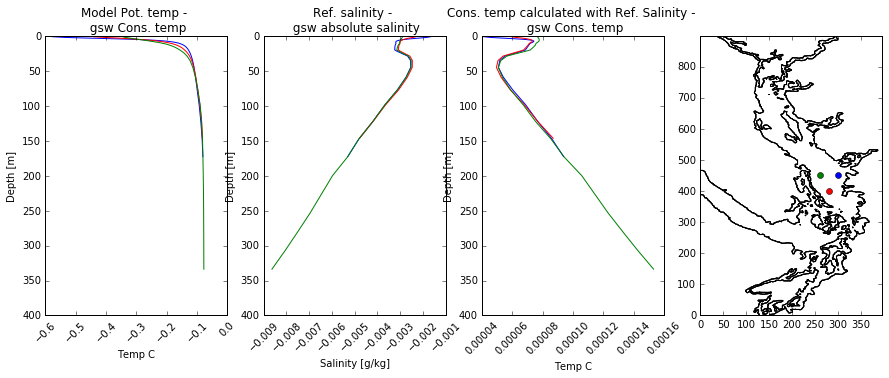

In [14]:
# Model potential - gsw conservative temperature
iss = [300, 280, 260]
jss = [450, 400, 450]
cols = ['b','r','g']
fig,axs = plt.subplots(1,4,figsize=(15,5))
for j,i,col in zip(jss, iss, cols):
    print ('color: {}'.format(col))
    compare_calculations(fnames, j, i, col, mesh, b, axs)
    print ('--------------------------------------------------')

* There are significant differences (on average > .5 deg C) between the potential temperature and conservative temperature in the surface SoG. This suggests we should be careful about how we are inputting river temperatures in nowcast-green. I'm not sure what NEMO does about heat fluxes from the atmopshere but there is a flag ln_useCT that converts sea surface temp frmo CT to PT before computer air-sea fluxes (see NEMO 3.6 docs page 93).
* The differences between reference salinity and absolute salinity (or Delta S) are small in the SoG (<0.01 g/kg). They get larger with depth. 
* There is practically no difference if we calculate conservative temperature with reference salinity vs calculating it with absolute salinity. Not sure why I cared about this... 

### In SJDF
#### Avaerage over summer months
How much difference between conservative and potential temperature is there in Juan de Fuca Strait?

color: b


/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/analyze.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if kss == 'None':


Model Pot. temp -  gsw Cons. temp ---  max diff: 0.08106197365938073
Ref. salinity -  gsw absolute salinity ---  max diff: 0.007581382302326745
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 0.00010909172036299708
--------------------------------------------------
color: r
Model Pot. temp -  gsw Cons. temp ---  max diff: 0.07859283906558012
Ref. salinity -  gsw absolute salinity ---  max diff: 0.006444467627410688
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 9.334706586017205e-05
--------------------------------------------------
color: g
Model Pot. temp -  gsw Cons. temp ---  max diff: 0.0756420093625163
Ref. salinity -  gsw absolute salinity ---  max diff: 0.005340388187647704
Cons. temp calculated with Ref. Salinity -  gsw Cons. temp ---  max diff: 7.85492384265396e-05
--------------------------------------------------


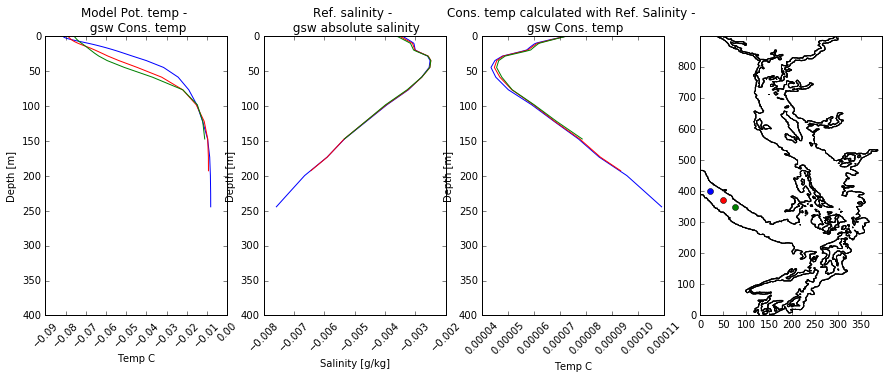

In [15]:
# Model potential - gsw conservative temperature
iss = [20, 50, 75]
jss = [400, 370, 350]
cols = ['b','r','g']
fig,axs = plt.subplots(1,4,figsize=(15,5))
for j,i,col in zip(jss, iss, cols):
    print ('color: {}'.format(col))
    compare_calculations(fnames, j, i, col, mesh, b, axs)
    print ('--------------------------------------------------')

* PT and CT differences are smaller than in surface SoG (<0.1 deg C)
* Again, Ref Salinity and abs salinity are pretty small (<0.01 g/kg).

# Summary
* This notebook looked at differences between conservative temperature and potential temperature for model nowcast results. The conservative temperature was calculated with the gsw library. 
* The point was to understand if we may have significant errors in model results because we haven't converted the inititial conditions and boundary conditions to conservative temperature. Also, we need to understand how we should compare model conservative temperature to temperature measurements/observations. 
* Differences between conservative and potential temperature are large (>.5 deg C) in the surface SoG. We should recognize this discrepancy when constructing initial conditions and boundary files.
* I also compared matlab teos-10 calculations for absolute salinity, conservative temperature and density and found very little difference. 

# Next steps
* We should probably convert initial conditions and boundary conditions to Conservative Temperature. Right now they are in Potential Temperature but NEMO assumes they are in Conservative Temperature.
* What do we do about river temperatures? Do they need to be converted to Conservative temperature? Look up in docs/code...
* Figure out what ln_useCT is and if we need to use it.  ln_useCT converts sea surface temp from CT to PT before computing air-sea fluxes (see NEMO 3.6 docs page 93). TEOS-10 primer page 5 says the appropriate temperature to use in air-sea interactions is insitu temperature. So I think we could use ln_useCT=True.
* Is Delta S big in our region. In other words, is reference salinity a good representation of absolute salinity? The TEOS-10 manual says that, in the absence of other any information, it is ok to use Delta S = 0 in coastal areas. I have an email from Rich that says how to report absolute salinity calculated with Delta S =0. Also see the TEOS-10 primer. 
* LiveOcean BCs will need to be converted to TEOS. Acutally, the units on salinty are a little bit unclear. I'm assuming they are PSU but it would be best to check. Temperature is described as potential temperature.
* We should think about how to compare model conservative temperature with observed 'in-situ' temperature. My understanding is for our depth ranges, potential temperature and insitu temperaure are not much different. But given the large differences between potential temperature and conservative temperature, we will need to be careful when comparing with observations.